### Part 1: Final model:
1. Train 25 binary genome models separately
2. Apply one pipeline to all binary genome models
    1. vectorizer: Tf-idf, uni-gram
    2. feature selection: chi-squared
    3. oversampling: SMOTE
    4. classifier: logistic regression (fast, easy to evaluate performance and adjust parameters)

### Part 2: Hyperparameters GridSearch codes example for one binary genome model
    ps: no enough computing capability to do all gridsearch.

### Part 3: Label raw data

### Part 1

In [57]:
import pandas as pd
import numpy as np
import nltk
import gensim
from bs4 import BeautifulSoup as bs
import re, string

from sklearn.model_selection import train_test_split, KFold
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import AdaBoostClassifier


import xgboost, textblob, string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from pprint import pprint

# import random
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [357]:
gen_df = pd.read_csv('dummies_abstract_sl_genome.csv')
gen_df.head(1)

,new_abstract_sl,Arts,Biodiversity and Habitat Protection,Business Development and Job Creation,Climate Change Mitigation and Adaptation,College and Career Readiness,Crime Prevention,Criminal Recidivism,Disability,Domestic Violence,...,Organizational Leadership,Poverty Alleviation,Quality of Education,Reproductive Health,STEM,Sports Performance,Student Achievement,Substance Abuse & Addictive Behavior,Workforce Development,Youth Development
0,abil evalu effect conserv intervent primarili ...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [358]:
# Number of abstracts in each genome
orders = gen_df.iloc[:, 1:].T.sum(axis=1).sort_values(ascending=False)
orders

Youth Development                           832
Student Achievement                         677
Quality of Education                        455
STEM                                        446
Food Security                               414
Early Childhood Education                   337
Criminal Recidivism                         315
Mental Health                               312
Poverty Alleviation                         303
Workforce Development                       266
College and Career Readiness                249
Obesity Prevention                          236
Domestic Violence                           227
Substance Abuse & Addictive Behavior        223
Business Development and Job Creation       183
Crime Prevention                            154
Reproductive Health                         145
Disability                                  141
Sports Performance                          139
Homelessness                                127
Arts                                    

In [33]:
# This pipeline serving as a baseline have reasonable parameters and methods learned from previous trials 
pipeline = Pipeline_imb([
    ('vect', TfidfVectorizer(max_features=3000, max_df=0.75)),
    ('select', SelectKBest(chi2, 2000)), 
    ('over', SMOTE(random_state=0)),
    ('clf', linear_model.LogisticRegression(C=5, random_state=0, class_weight='balanced')),
])

def kfold_validation(y, X, ppl=pipeline, kf=10):
    '''
    Apply k-fold validation to evaluate model performance
    
    '''
    k_fold = KFold(kf, random_state=0, shuffle=True) # shuffle data is necessary to have reseable k folds

    y_label = np.array([])
    y_prob = np.array([])
    y_pred = np.array([])
    
    for k, (train, test) in enumerate(k_fold.split(X, y)):
        # print(k)
        ppl.fit(X[train], y[train])
        # Record labels of shuffled data
        y_label = np.append(y_label, y[test])
        # Append predictions
        y_prob = np.append(y_prob, ppl.predict_proba(X[test]))        
        y_pred = np.append(y_pred, ppl.predict(X[test]))
    
    
    y_prob = y_prob.reshape(y_label.shape[0], 2)

    return (ppl, y_prob, y_pred, y_label)

0 Youth Development

 precision at recall=0.5:  0.8109161793372319
auc:  0.9475868422194579 

1 Student Achievement

 precision at recall=0.5:  0.7915690866510539
auc:  0.9540526732413531 

2 Quality of Education

 precision at recall=0.5:  0.6404494382022472
auc:  0.9524186436916903 

3 STEM

 precision at recall=0.5:  0.948936170212766
auc:  0.9895018993830149 

4 Food Security

 precision at recall=0.5:  0.9951923076923077
auc:  0.9990706210121346 

5 Early Childhood Education

 precision at recall=0.5:  0.9657142857142857
auc:  0.9935425611580714 

6 Criminal Recidivism

 precision at recall=0.5:  0.9349112426035503
auc:  0.9917302539410509 

7 Mental Health

 precision at recall=0.5:  0.9512195121951219
auc:  0.9900019544803718 

8 Poverty Alleviation

 precision at recall=0.5:  0.9681528662420382
auc:  0.9967019277607597 

9 Workforce Development

 precision at recall=0.5:  0.8260869565217391
auc:  0.9754233476280777 

10 College and Career Readiness

 precision at recall=0.5:  0

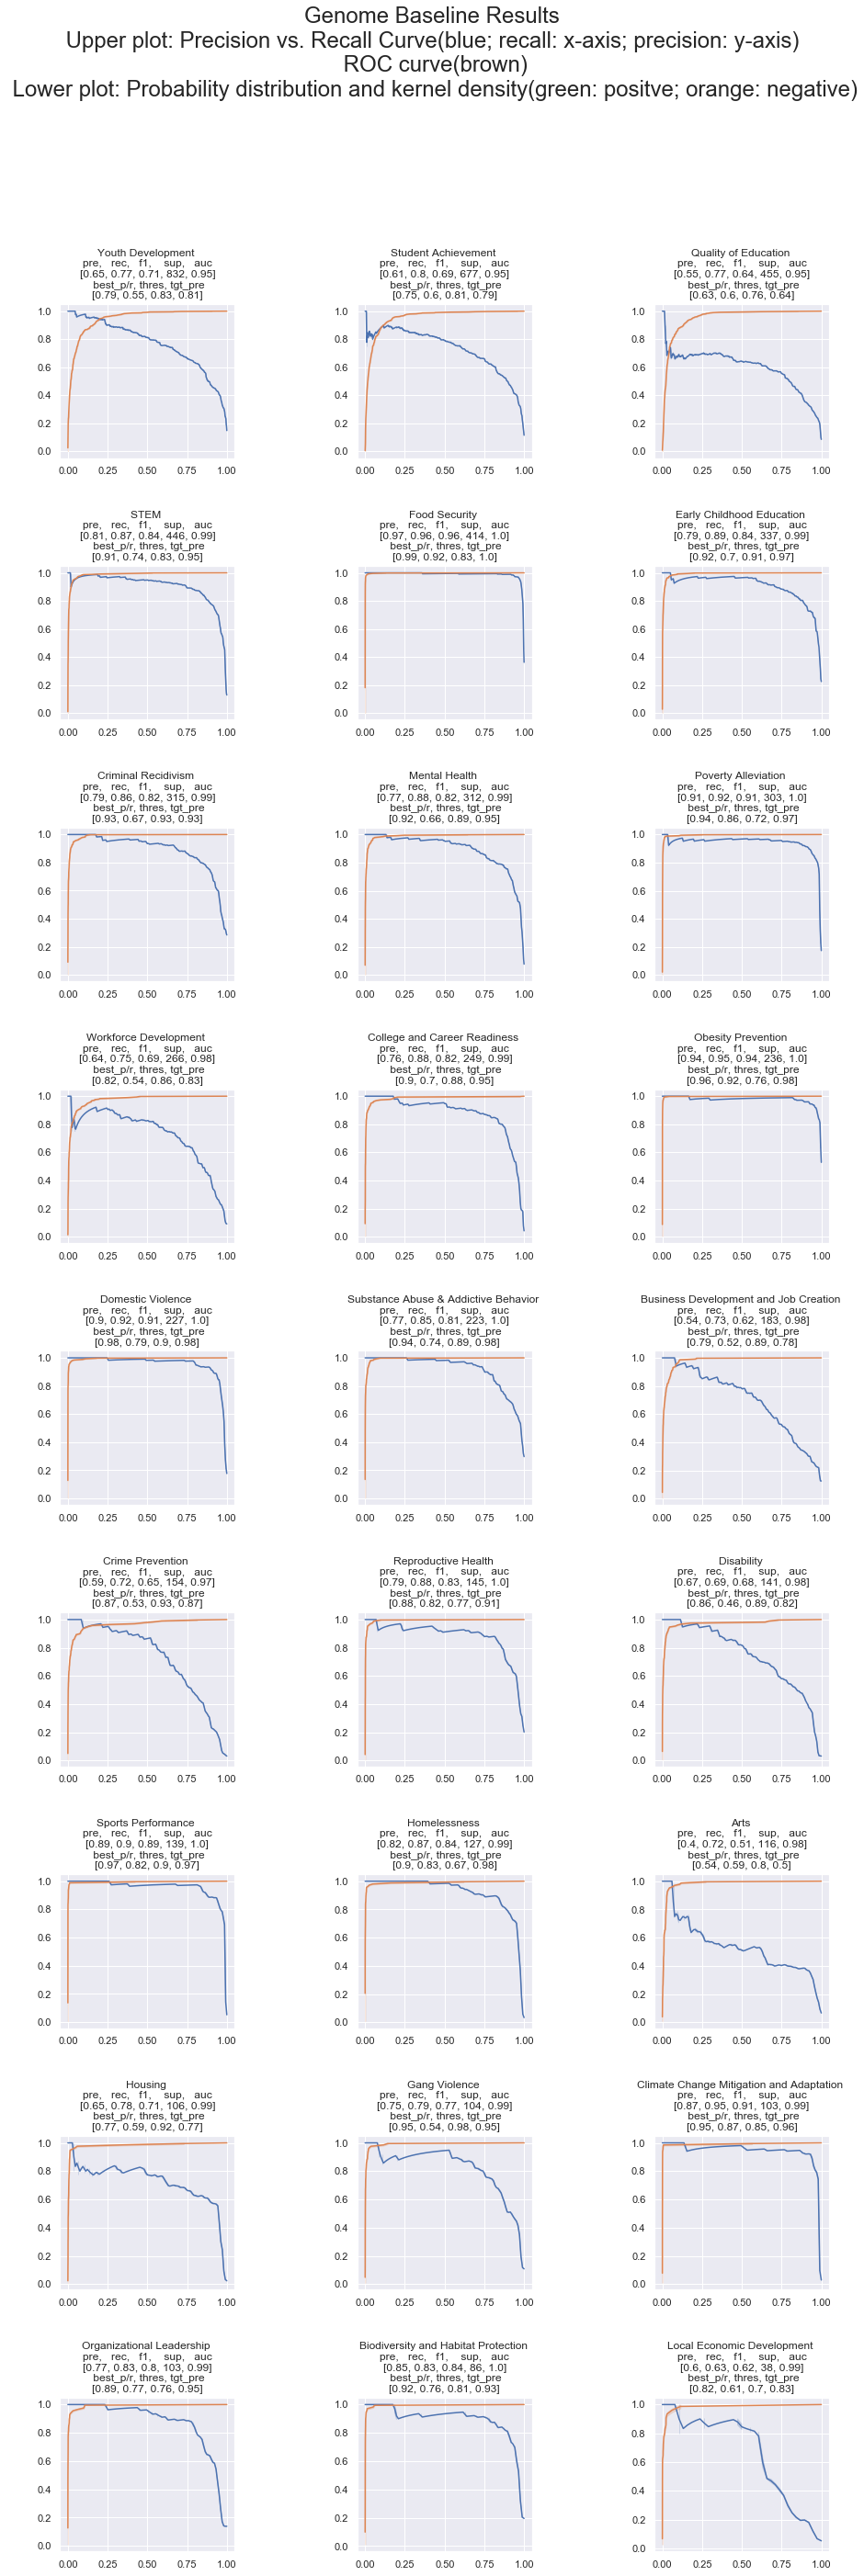

In [359]:
TGT_RECALL = 0.5 # target recall
ALPHA = 0.5 # adjust weights for precision and recall to calculate f-score
X = np.array(gen_df['new_abstract_sl'])

models = {}
results = {}
fig, axs = plt.subplots(ncols=3,nrows=9, figsize=(15,45))
fig.subplots_adjust(hspace=0.7, wspace=0.7)
fig.suptitle(\
'Genome Baseline Results\n Upper plot: Precision vs. Recall Curve(blue; recall: x-axis; precision: y-axis) \n ROC curve(brown)\n Lower plot: Probability distribution and kernel density(green: positve; orange: negative)', size=24)

for i in range(len(orders)):
    name = orders.index[i]
    print(i, name)
    # define y
    y_gen = np.array(gen_df[name]) 
    
    (ppl, y_prob, y_pred, y_label) = kfold_validation(y=y_gen, X=X)
    
    # Calculate precison, recall, auc, target-precision at recall=0.5(tgt_pre)
    precision, recall, thr = metrics.precision_recall_curve(y_label, y_prob[:,1])
    tgt_pre = precision[np.argmin(abs(recall-TGT_RECALL))] # precision where recall=0.5
    print('\n precision at recall=0.5: ', tgt_pre)

    fpr, tpr, thresholds = metrics.roc_curve(y_label, y_prob[:,1])
    auc = metrics.auc(fpr, tpr)
    print("auc: ", auc, '\n')    
    models[name] = (ppl, y_prob, y_pred, y_label)

    # Calculate f-score, emphasize on precision by asigning ALPHA = 0.5
    f1 = (1 + ALPHA**2) * (precision * recall) / (ALPHA**2 * (precision) + recall)
    f1[np.where(np.isnan(f1))] = -1
    max_f1 = np.argmax(f1)
    thres = thr[max_f1]
    # Record precision and recall @ max f-score
    best_pre = precision[max_f1]
    best_rec = recall[max_f1]

    # record prediction performance given by sklearn
    sklearn_pred = [x[1] for x in metrics.precision_recall_fscore_support(y_label.tolist(), y_pred)]
    results[name] = sklearn_pred + [auc, best_pre, best_rec, thres, tgt_pre]
    
    # Plot recall-precision curve and ROC curve
    row = (i//3)
    col = i%3
    sns.lineplot(recall, precision, ax=axs[row, col])
    ax1 = sns.lineplot(fpr, tpr, ax=axs[row, col])

    
    numbers = [round(x,2) for x in results[name]]
    ax1.set_title('{} \npre,   rec,   f1,    sup,   auc\n{}\n best_p/r, thres, tgt_pre\n{}'.format(\
                                                                name, numbers[:5], numbers[5:]))

fig.savefig('genome_baseline_10fold.png')


In [360]:
result_df = pd.DataFrame(results).T

result_df = pd.concat([orders, result_df], axis=1)
result_df.columns = ['count', 'precision', 'recall', 'f1', 'support', 'auc', \
                                   'best_precision', 'best_recall', 'threshold', 'target_precision@recall=.5']
result_df['good'] = (result_df['best_precision'] >= 0.7) & (result_df['best_recall'] >= 0.7) | \
          (result_df['target_precision@recall=.5']>=0.8)
    
result_df.to_csv('genome_baseline_10fold.csv')

In [361]:
pd.DataFrame(models, index=['pipeline', 'probability', 'prediction', 'y_label']).T.to_csv('genome_models.csv')

### Part 2 Grid Search

In [51]:

def build_model(X_input, y_input, pipeline, parameters, scorer='precision'):
    '''
    Do grid search, find the best model, and evaluate its performance (cross validation)
    '''
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=scorer)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_input, y_input)
    
    # Print progress
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best precision score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    # Cross validation
    perform = kfold_validate(X_input, y_input, grid_search.best_estimator_)

    
    return (grid_search, perform)

def kfold_validate(X, y, model, kf=5):
    '''
    k-fold cross validation
    '''
    k_fold = KFold(kf, random_state=0, shuffle=True)

    y_label = np.array([])
    y_prob = np.array([])
    
    for k, (train, test) in enumerate(k_fold.split(X, y)):
        print(k)
        model.fit(X[train], y[train])

        y_label = np.append(y_label, y[test])
        y_prob = np.append(y_prob, model.predict_proba(X[test]))
        
    y_prob = y_prob.reshape(y_label.shape[0], 2)
    
    
    precision, recall, thr = metrics.precision_recall_curve(y_label, y_prob[:,1])
    tgt = precision[np.argmin(abs(recall-0.5))]
    print('\n precision at recall=0.5: ', tgt)
    
    # calucate ROC AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_label, y_prob[:,1])
    print("auc: ", metrics.auc(fpr, tpr), '\n') 
    
    # Plot recall-precision curve
    plt.plot(recall, precision, lw=0.2)    

    return tgt   

Youth Development
Performing grid search...
pipeline: ['vect', 'select', 'over', 'clf']
parameters:
{'clf__C': (1, 5, 10),
 'select__k': (500, 1000, 2000),
 'vect__max_df': (0.5, 0.75),
 'vect__max_features': (2000, 3000, 5000),
 'vect__ngram_range': ((1, 2), (1, 1))}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 11.7min finished


done in 704.797s

Best precision score: 0.704
Best parameters set:
	clf__C: 10
	select__k: 2000
	vect__max_df: 0.5
	vect__max_features: 2000
	vect__ngram_range: (1, 2)
0
1
2
3
4

 precision at recall=0.5:  0.851508120649652
auc:  0.9507430229709612 



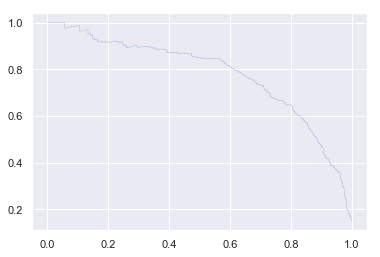

In [59]:
# Logistic Regression
pipeline = Pipeline_imb([
    ('vect', TfidfVectorizer()),
    ('select', SelectKBest(chi2)), 
    ('over', SMOTE(random_state=0)),
    ('clf', linear_model.LogisticRegression(random_state=0, class_weight='balanced')),
])


parameters = {
    'vect__ngram_range': ((1,2), (1,1)),
    'vect__max_df': (0.5, 0.75),
    'vect__max_features': (2000, 3000, 5000),
#     'over__k_neighbors': (1, 5, 10),        
    'select__k': (500, 1000, 2000),
#     'clf__penalty': ('l1', 'l2'),
    'clf__C': (1, 5, 10)
}



X = np.array(gen_df['new_abstract_sl'])
name = orders.index[0]
print(name)
y = np.array(gen_df[name]) 

# scorer is chosen from ('precision', 'f1', 'recall', etc.)
grid_search, perform = build_model(X, y, pipeline, parameters, scorer='precision')

Youth Development
Performing grid search...
pipeline: ['vect', 'select', 'over', 'clf']
parameters:
{'select__k': (500, 1000, 2000),
 'vect__max_df': (0.5, 0.75),
 'vect__max_features': (2000, 3000, 5000),
 'vect__ngram_range': ((1, 2), (1, 1))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.7min finished


done in 227.069s

Best precision score: 0.512
Best parameters set:
	select__k: 2000
	vect__max_df: 0.5
	vect__max_features: 3000
	vect__ngram_range: (1, 2)
0
1
2
3
4

 precision at recall=0.5:  0.8475750577367206
auc:  0.9584708638764833 



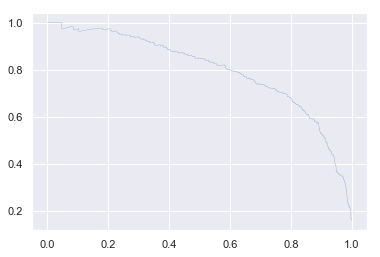

In [60]:
# Naive Bayes
pipeline = Pipeline_imb([
    ('vect', TfidfVectorizer()),
    ('select', SelectKBest(chi2)), 
    ('over', SMOTE(random_state=0)),
    ('clf', naive_bayes.MultinomialNB()),
])


parameters = {
    'vect__ngram_range': ((1,2), (1,1)),
    'vect__max_df': (0.5, 0.75),
    'vect__max_features': (2000, 3000, 5000),      
    'select__k': (500, 1000, 2000),
}

X = np.array(gen_df['new_abstract_sl'])
name = orders.index[0]
print(name)
y = np.array(gen_df[name]) 

# scorer in ('precision', 'f1', 'recall', etc.)
grid_search, perform = build_model(X, y, pipeline, parameters, scorer='precision')

Youth Development
0
1
2
3
4

 precision at recall=0.5:  0.6178451178451179
auc:  0.8744213918254282 



0.6178451178451179

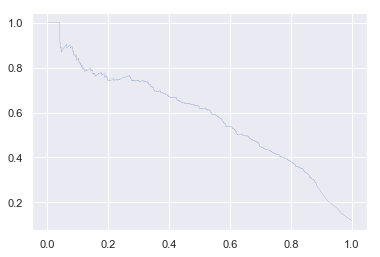

In [70]:
# SVM (not try grid search, very slow)
pipeline = Pipeline_imb([
    ('vect', TfidfVectorizer()),
    ('select', SelectKBest(chi2)), 
    ('over', SMOTE(random_state=0)),
    ('clf', svm.SVC(probability=True, random_state=0, class_weight='balanced')),
])


X = np.array(gen_df['new_abstract_sl'])
name = orders.index[0]
print(name)
y = np.array(gen_df[name]) 

pipeline.fit(X, y)
kfold_validate(X, y, pipeline)

## Part 3 Label raw data

In [362]:
raw = pd.read_csv('raw_data.csv', index_col=0)
raw.head(1)

,Publication ID,Title,Abstract,Abstract_sl,Title_sl,Abstract_lem,Title_lem,Abstract_stem,Title_stem
0,pub.1000001894,institutional support managerial capacity buil...,quality managerial skills cited crucial import...,qualiti manageri skill cite crucial import ing...,institut support manageri capac build smes growth,quality managerial skill cited crucial importa...,institutional support managerial capacity buil...,qualiti manageri skill cite crucial import ing...,institut support manageri capac build smes growth


In [363]:
pipeline = Pipeline_imb([
    ('vect', TfidfVectorizer(max_features=3000, max_df=0.75)),
    ('select', SelectKBest(chi2, 2000)), 
    ('over', SMOTE(random_state=0)),
    ('clf', linear_model.LogisticRegression(C=5, random_state=0, class_weight='balanced')),
])

for i in range(len(orders)):
    X = np.array(gen_df['new_abstract_sl'])
    name = orders.index[i]
    print(i, name)
    y = np.array(gen_df[name]) 
    pipeline.fit(X, y)
    
    # predict probability
    prob = pipeline.predict_proba(raw['Abstract_sl'])[:,1]
    raw[name] = pd.Series(prob)
    
    # retrieve model performance
    (ppl, y_prob, y_pred, y_label) = models[name]
        
    precision_1, recall_1, thr_1 = metrics.precision_recall_curve(y_label, y_prob[:,1], 1)
    # the threshold when recall=0.7
    threshold = thr_1[np.argmin(abs(recall_1-0.7))]
    
    # label data
    col = name + '_' + str(round(threshold, 2))    
    raw[col] = prob>=threshold
    raw[col] = raw[col].apply(lambda x: 1 if x else 0)

0 Youth Development
1 Student Achievement
2 Quality of Education
3 STEM
4 Food Security
5 Early Childhood Education
6 Criminal Recidivism
7 Mental Health
8 Poverty Alleviation
9 Workforce Development
10 College and Career Readiness
11 Obesity Prevention
12 Domestic Violence
13 Substance Abuse & Addictive Behavior
14 Business Development and Job Creation
15 Crime Prevention
16 Reproductive Health
17 Disability
18 Sports Performance
19 Homelessness
20 Arts
21 Housing
22 Gang Violence
23 Climate Change Mitigation and Adaptation
24 Organizational Leadership
25 Biodiversity and Habitat Protection
26 Local Economic Development


In [364]:
raw.head(2)

,Publication ID,Title,Abstract,Abstract_sl,Title_sl,Abstract_lem,Title_lem,Abstract_stem,Title_stem,Youth Development,...,Gang Violence,Gang Violence_0.74,Climate Change Mitigation and Adaptation,Climate Change Mitigation and Adaptation_0.95,Organizational Leadership,Organizational Leadership_0.84,Biodiversity and Habitat Protection,Biodiversity and Habitat Protection_0.85,Local Economic Development,Local Economic Development_0.27
0,pub.1000001894,institutional support managerial capacity buil...,quality managerial skills cited crucial import...,qualiti manageri skill cite crucial import ing...,institut support manageri capac build smes growth,quality managerial skill cited crucial importa...,institutional support managerial capacity buil...,qualiti manageri skill cite crucial import ing...,institut support manageri capac build smes growth,0.002768,...,0.000919,0,0.008424,0,0.005783,0,0.008581,0,0.007230,0
1,pub.1000003910,characterization antibiotic resistance gene ab...,one recent trends animal production revival in...,one recent trend anim product reviv interest o...,character antibiot resist gene abund microbiot...,one recent trend animal production revival int...,characterization antibiotic resistance gene ab...,one recent trend anim product reviv interest o...,character antibiot resist gene abund microbiot...,0.042911,...,0.012629,0,0.019714,0,0.033868,0,0.234084,0,0.011566,0


In [365]:
raw.to_csv('genome_labeled.csv')

In [366]:
# how many ones
raw.iloc[:, 10::2].sum(axis=0).sum()

9169

In [367]:
# how many abstracts are classified as one the of genomes
(raw.iloc[:, 10::2].sum(axis=1)==1).sum()

7669

In [368]:
# how many abstracts are classified to each genome
raw.iloc[:, 10::2].sum(axis=0)

Youth Development_0.63                           1315
Student Achievement_0.68                          254
Quality of Education_0.6                          376
STEM_0.88                                          97
Food Security_0.99                                375
Early Childhood Education_0.91                    767
Criminal Recidivism_0.89                          244
Mental Health_0.85                               1735
Poverty Alleviation_0.94                           57
Workforce Development_0.63                        780
College and Career Readiness_0.88                  20
Obesity Prevention_0.99                           472
Domestic Violence_0.95                            141
Substance Abuse & Addictive Behavior_0.91         298
Business Development and Job Creation_0.56        358
Crime Prevention_0.55                             230
Reproductive Health_0.91                          406
Disability_0.48                                   285
Sports Performance_0.98     

In [369]:
(ppl, y_prob, y_pred, y_label) = models['Student Achievement']
precision_0, recall_0, thr_0 = metrics.precision_recall_curve(y_label, y_prob[:,0], 0)
precision_1, recall_1, thr_1 = metrics.precision_recall_curve(y_label, y_prob[:,1], 1)

print('How many articles are class 1: ')
print(sum(y_label))
print('how many articles are labeled as 0 when preicison for class 0 is 0.99: ')
print(sum(y_prob[:,0] > thr_0[np.argmin(abs(precision_0-0.99))]))
print('how many articles are labeled as 1 when preicison for class 1 is 0.8: ')
print(sum(y_prob[:,1] > thr_1[np.argmin(abs(precision_1-0.8))]))
print('recall when precision for class 1 is 0.8: ')
print(recall_1[np.argmin(abs(precision_1-0.8))])

How many articles are class 1: 
677.0
how many articles are labeled as 0 when preicison for class 0 is 0.99: 
4699
how many articles are labeled as 1 when preicison for class 1 is 0.8: 
39
recall when precision for class 1 is 0.8: 
0.047267355982274745
